# Integer Linear Programming

Primal problem:

* `maximize` $\sum_{t=1}^{m}x_t - \rho\sum_{i=1}^{n}\sum_{j=1}^{q}\chi_{(i, j)}$
* Equivalent to: `minimize` $\rho\sum_{i=1}^{n}\sum_{j=1}^{q}\chi_{(i, j)} - \sum_{t=1}^{m}x_t$

subject to constraints:
1. $\frac{\alpha_t}{n} \le x_t \le \alpha_t,$ $\forall t=1,2, \dots, m$
2. $x_t \in \left[0, k_t\right],$ $\forall t = 1, 2, \dots, m$
3. $\sum_{j=1}^{q}\chi_{(i, j)} \le 1,$ $\forall i = 1, 2, \dots, n$
4. $\chi_{(i, j)} \in \{0, 1\},$ $\forall i=1, 2, \dots, n,$ $\forall j=1,2, \dots, q$

We have $m+nq$ variables and $2m+n+nq$ constraints

# Implementation

In [1]:
import numpy as np
from scipy.optimize import milp, LinearConstraint, Bounds
from matplotlib import pyplot as plt
from matplotlib import patches as ptc
import json
import tqdm
import pandas as pd
import pickle

## Prepare data

In [2]:
!gdown 1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
!gdown 1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
with open("fix_sensors.pkl", 'rb') as f:
  fs_data = pickle.load(f)

with open("fix_targets.pkl", 'rb') as f:
  ft_data = pickle.load(f)

data = {
  'fixed-sensor': fs_data,
  'fixed-target': ft_data
}

## Utils

In [4]:
def make_pan_boundaries(centroid, q, radius):
    # first line always lies on x_axis
    ans = []
    theta = 2*np.pi/q
    for i in range(q):
        x = radius*np.cos(theta*i)
        y = radius*np.sin(theta*i)
        ans.append((centroid[0] + x, centroid[1] + y))

    return ans

In [5]:
def show_network(network, sensors_mask=None, figsize=None):
    if figsize is not None:
      plt.figure(figsize=(figsize, figsize))

    x_lim = network['margin'][0]
    y_lim = network['margin'][1]

    targets = network['targets']
    sensors = network['sensors']
    radius = network['radius']
    q = network['q']
    tar_x = [i[0] for i in targets]
    tar_y = [i[1] for i in targets]
    plt.plot(tar_x, tar_y, 'r^', label='targets')
    sen_x = [i[0] for i in sensors]
    sen_y = [i[1] for i in sensors]
    plt.plot(sen_x, sen_y, 'go', label='sensors')
    ax = plt.gca()

    for i in range(len(sensors)):
        sensor = sensors[i]
        active = True

        if sensors_mask is not None:
            active = False
            theta = 360.0/q
            for j in range(q):
                if sensors_mask[q*i+j] == 1:
                    active = True
                    theta1, theta2 = theta*j, theta*(j+1)
                    wedge = ptc.Wedge(sensors[i], radius, theta1, theta2, color='#34e1eb', alpha=0.45)
                    ax.add_artist(wedge)
        if active:
          circle = plt.Circle(sensor, radius, color='m', fill=False, linewidth=1)
          ax.add_artist(circle)
          pan_boundaries = make_pan_boundaries(sensor, q, radius)
          for point in pan_boundaries:
              plt.plot([sensor[0], point[0]], [sensor[1], point[1]], 'b--', alpha=0.2)

    plt.xlim([x_lim[0], x_lim[1]])
    plt.ylim([y_lim[0], y_lim[1]])
    ax.set_aspect(1.0)  # make aspect ratio square

    plt.legend()

    plt.show()

In [6]:
def is_within_FoV(bisector, target, sensor, radius):
    target = np.asarray(target)
    sensor = np.asarray(sensor)
    bisector = np.asarray(bisector)
    v = target - sensor
    dist = np.linalg.norm(v)
    scalar = bisector.dot(v)
    return scalar + 1e-7 >= radius*dist*np.cos(np.pi/8) and dist - 1e-7 <= radius

def init_Gt(m, n, q, radius, targets, sensors):
    Gt = np.zeros((m, n*q))
    bisectors = []
    for i in range(8):
        bisectors.append((radius*np.cos(np.pi/8+i*np.pi/4), radius*np.sin(np.pi/8+i*np.pi/4)))

    for g in range(m):
        for i in range(n):
            for j in range(q):
                Gt[g, q*i+j] = is_within_FoV(bisectors[j], targets[g], sensors[i], radius)
    return Gt


## Represent input

In [7]:
network_scale = 'small'
network_data = data['fixed-sensor'][0][network_scale]
id = 10

m = network_data[id]['m']    # number of targets
n = network_data[id]['n']    # number of sensors
q = network_data[id]['q']    # number of pans
targets = network_data[id]['targets']
sensors = network_data[id]['sensors']
radius = network_data[id]['radius']
len_var = m + n*q
print(f'{len_var} variables')
K = network_data[id]['K']
Gt = init_Gt(m, n, q, radius, targets, sensors)

253 variables


In [8]:
# check Gt
for i in range(m):
    print(f'Target {i} with pos {targets[i]} tracked by:')

    for j in range(n):
            for k in range(q):
                if Gt[i, q*j+k] == 1:
                    print(f'\tSensor {j} with pos {sensors[j]} at pan {k}')


Target 0 with pos [19.67912994 12.9707189 ] tracked by:
	Sensor 9 with pos [21.94723974 13.33040811] at pan 4
	Sensor 15 with pos [30.00973294  8.33458012] at pan 3
Target 1 with pos [132.06054394 115.99675749] tracked by:
	Sensor 27 with pos [137.62694122 132.27412221] at pan 5
Target 2 with pos [152.87453244 112.29691759] tracked by:
Target 3 with pos [ 53.00928567 112.13201888] tracked by:
	Sensor 4 with pos [ 48.24029152 127.44029536] at pan 6
Target 4 with pos [  4.18899221 120.69753332] tracked by:
Target 5 with pos [ 16.4343335  135.29358745] tracked by:
Target 6 with pos [193.57200697 160.99779994] tracked by:
Target 7 with pos [59.0889555  53.96414403] tracked by:
Target 8 with pos [153.84462957 165.00988204] tracked by:
	Sensor 6 with pos [160.30742238 179.02354814] at pan 5
	Sensor 22 with pos [157.00330877 147.50167189] at pan 2
Target 9 with pos [124.93271377  99.65113645] tracked by:
	Sensor 10 with pos [109.59189779 103.68160439] at pan 7
Target 10 with pos [76.38792793 

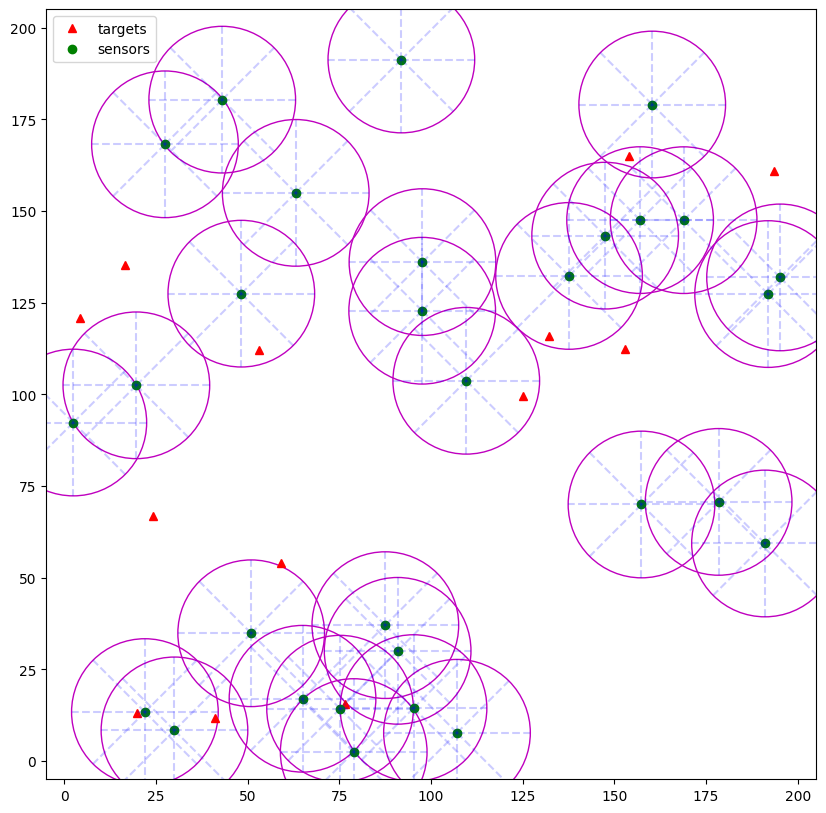

In [9]:
show_network(network_data[id], figsize=10)

## Make function for solving ILP

In [10]:
def solve_ILP(network, verbose=True):
  # constants
  m = network['m']
  n = network['n']
  q = network['q']
  targets = network['targets']
  sensors = network['sensors']
  radius = network['radius']
  len_var = m + n*q
  if verbose:
    print(f'ILP with {len_var} variables')
  rho = 0.0001
  K = network['K']
  Gt = init_Gt(m, n, q, radius, targets, sensors)

  # objective function coefficient
  c = np.concatenate((-np.ones((m,)), rho*np.ones((n*q,)))) # 1D array

  # linear constraints
  A1 = np.zeros((m, len_var))
  for i in range(m):
      A1[i, i] = 1
      A1[i, m:] = -Gt[i]
  lower_bound_1 = np.full((m,), -np.inf)
  upper_bound_1 = np.zeros((m,))
  ct1 = LinearConstraint(A=A1, lb=lower_bound_1, ub=upper_bound_1,keep_feasible=False)

  A2 = np.zeros((m, len_var))
  for i in range(m):
      A2[i, i] = 1
      A2[i, m:] = -Gt[i]/m
  lower_bound_2 = np.zeros((m,))
  upper_bound_2 = np.full((m,), np.inf)
  ct2 = LinearConstraint(A=A2, lb=lower_bound_2, ub=upper_bound_2,keep_feasible=False)

  A3 = np.zeros((n, len_var))
  for i in range(n):
      A3[i, m+q*i: m+q*i+q] = np.ones((q,))
  lower_bound_3 = np.zeros((n,))
  upper_bound_3 = np.ones((n,))
  ct3 = LinearConstraint(A=A3,lb=lower_bound_3, ub=upper_bound_3, keep_feasible=False)

  # bound
  lower_bound_4 = np.zeros((len_var,))
  upper_bound_4 = np.concatenate((K, np.ones((n*q,))))
  bound = Bounds(lb=lower_bound_4, ub=upper_bound_4, keep_feasible=False)

  constraints = [ct1, ct2, ct3]

  integrality = np.ones_like(c)

  # solve
  ilp = milp(c=c, constraints=constraints, bounds=bound, integrality=integrality)
  if verbose:
    print("Found the optimal value: ", c.dot(ilp.x))

  achieved_coverage = ilp.x[:m]
  sensors_mask = ilp.x[m:]

  return achieved_coverage, sensors_mask


## Solve ILP

In [11]:
achieved_coverage, sensors_mask = solve_ILP(network_data[id])

ILP with 253 variables
Found the optimal value:  -7.9992


In [12]:
# get achieve coverage
print('Expected:', network_data[id]['K'])
print('Achieved:', achieved_coverage)

Expected: [2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2]
Achieved: [1. 1. 0. 1. 0. 0. 0. 0. 2. 1. 1. 1. 0.]


## Represent solution

In [13]:
# get active sensors
sensors_mask

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0.

**Visualize**

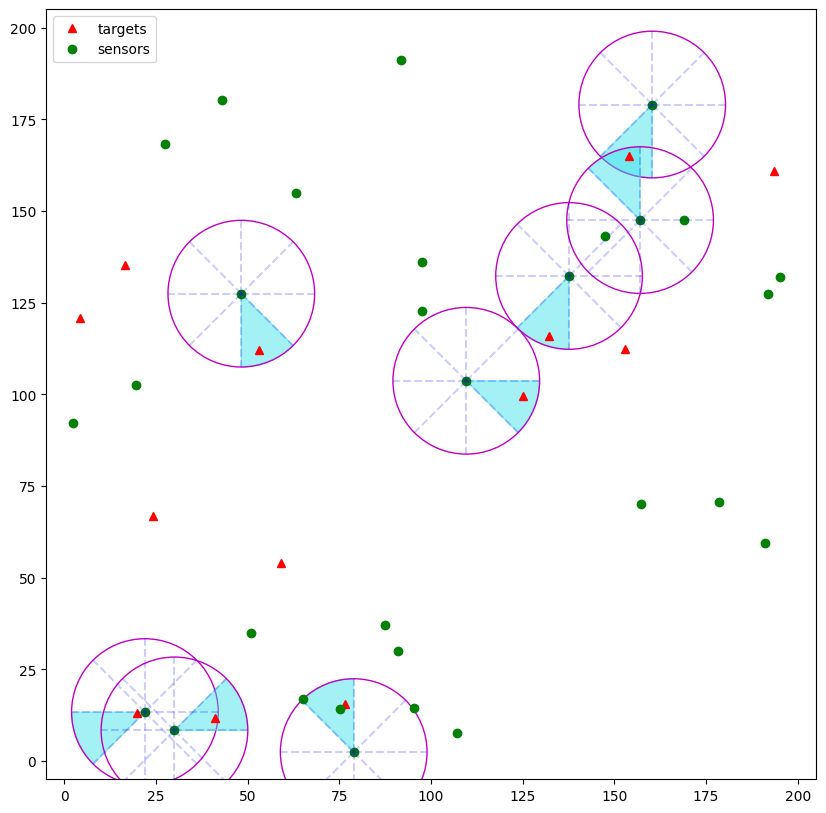

In [14]:
show_network(network_data[id], sensors_mask, figsize=10)

# Performance metrics

## Distance index

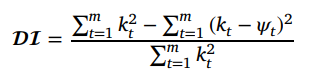

In [15]:
def distance_index(k, x):
  a = np.sum(k*k)
  b = k - x
  b = np.sum(b*b)
  return 1 -b/a

## Variance

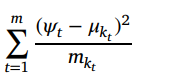

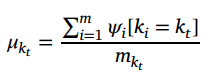

In [16]:
def variance(k, x):
  m = len(x)
  mk = np.zeros_like(x)
  for t in range(m):
    mk[t] = np.sum(k == k[t])
  nu_k = np.zeros_like(x)
  for t in range(m):
    ans = 0
    for i in range(m):
      ans += x[i]*(k[i] == k[t])
    nu_k[t] = ans/mk[t]

  a = (x - nu_k)

  return np.sum(a*a/mk)


## Activated Sensors

In [17]:
def activated_sensors(n_sensors, q, mask):
  cnt = 0
  for i in range(n_sensors):
    for j in range(q):
      if mask[q*i+j] == 1:
        cnt += 1

  return cnt

In [18]:
def coverage_quality(mask, network):
  sensors = network['sensors']
  targets = network['targets']
  radius = network['radius']
  n = network['n']
  m = network['m']
  q = network['q']
  T = np.zeros((n, q, m), dtype=bool)

  bisectors = []
  for i in range(q):
      bisectors.append((radius*np.cos(np.pi*(1 + i*2)/q), radius*np.sin(np.pi*(1 + i*2)/q)))

  for i in range(n):
      for j in range(m):
          for p in range(q):
              T[i, p, j] = is_within_FoV(bisectors[p], targets[j], sensors[i], radius)

  U = np.zeros((n, q, m), dtype=float)
  for i in range(n):
    for j in range(m):
        for p in range(q):
          if T[i, p, j]:
            target = np.asarray(targets[j])
            sensor = np.asarray(sensors[i])
            v = target - sensor
            U[i, p, j] = 1 - np.square(np.linalg.norm(v)/radius)

  S = np.zeros((n, q), dtype=bool)
  for i in range(n):
    for j in range(q):
      if mask[i*q+j] == 1:
        S[i, j] = True

  return np.sum(np.sum(U, axis=2)*S)

# Evaluate

## Fixed sensor

In [19]:
# small_fs = data2['fixed-sensor']['small']

### Distance index

In [20]:
DI_fs_small = []
VAR_fs_small = []
CQ_fs_small = []
ACT_fs_small = []
for i in range(10):
  di = []
  var = []
  cq = []
  act = []
  for dt in tqdm.tqdm(fs_data[i]['large']):
    achieved_coverage, mask = solve_ILP(dt, verbose=False)
    DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
    var_score = variance(np.asarray(dt['K']), achieved_coverage)
    cq_score = coverage_quality(mask, dt)
    act_score = activated_sensors(dt['n'], dt['q'], mask)
    di.append(DI_score)
    var.append(var_score)
    cq.append(cq_score)
    act.append(act_score)
  DI_fs_small.append(di)
  VAR_fs_small.append(var)
  CQ_fs_small.append(cq)
  ACT_fs_small.append(act)
ilp_fs_large= [DI_fs_small, VAR_fs_small, CQ_fs_small, ACT_fs_small]
# goi lai thanh 1 file
import pickle
with open("ilp_fs_large.pkl", "wb") as f:
  pickle.dump(ilp_fs_large, f)



100%|██████████| 175/175 [01:45<00:00,  1.66it/s]


In [21]:
DI_fs_avg = np.mean(DI_fs_small, axis=0)
VAR_fs_avg = np.mean(VAR_fs_small, axis=0)
CQ_fs_avg = np.mean(CQ_fs_small, axis=0)

In [22]:
# di_fs
!gdown 1K2qpuzicc7-F85zx3dz-JL8KCee_PD0K
# var_fs
!gdown 1aGOa6O2VTZPQ3m9_6n1Jn6e4NpzKhH8l
# cq_fs
!gdown 1RCoLMOFtftxEiolCBS6RadgWpW5Uwzff

'gdown' is not recognized as an internal or external command,
operable program or batch file.


'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
di_fs = pd.read_csv('/content/distance_index_fix_sensor.csv')
var_fs = pd.read_csv('/content/variance.csv')
cq_fs = pd.read_csv('/content/CQ_fix_sensor.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/distance_index_fix_sensor.csv'

In [ ]:
df = pd.DataFrame({'ILP': DI_fs_avg,
                   'PIQP': di_fs['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Distance_Index_fs.csv')

In [ ]:
df = pd.DataFrame({'ILP': VAR_fs_avg,
                   'PIQP': var_fs['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Variance_fs.csv')

In [ ]:
df = pd.DataFrame({'ILP': CQ_fs_avg,
                   'PIQP': cq_fs['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/CQ_fs.csv')

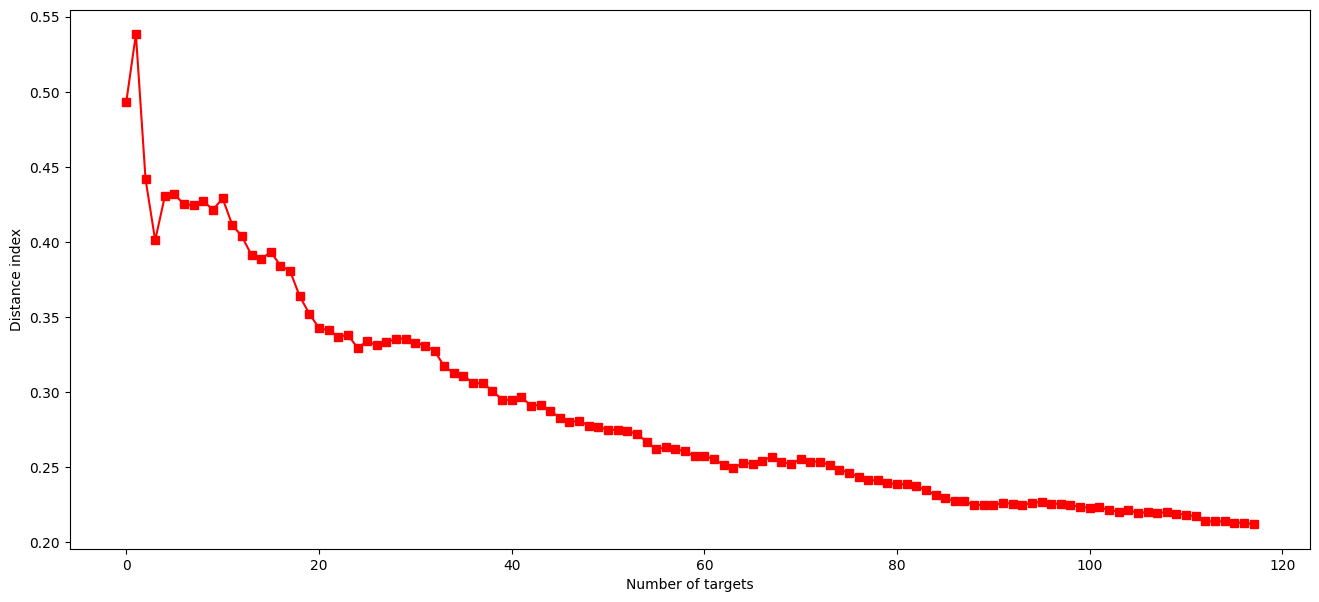

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(DI_fs_avg))
plt.plot(x_axis, DI_fs_avg, 'r-')
plt.plot(x_axis, DI_fs_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Distance index")
plt.show()

### Variance

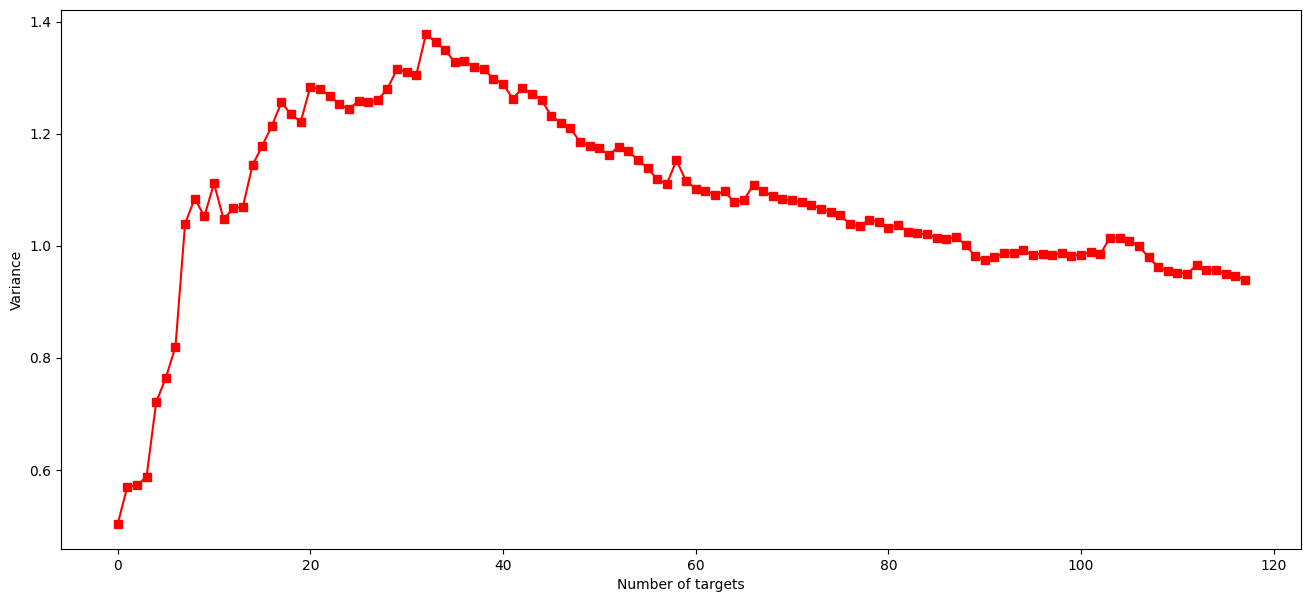

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(VAR_fs_avg))
plt.plot(x_axis, VAR_fs_avg, 'r-')
plt.plot(x_axis, VAR_fs_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.show()

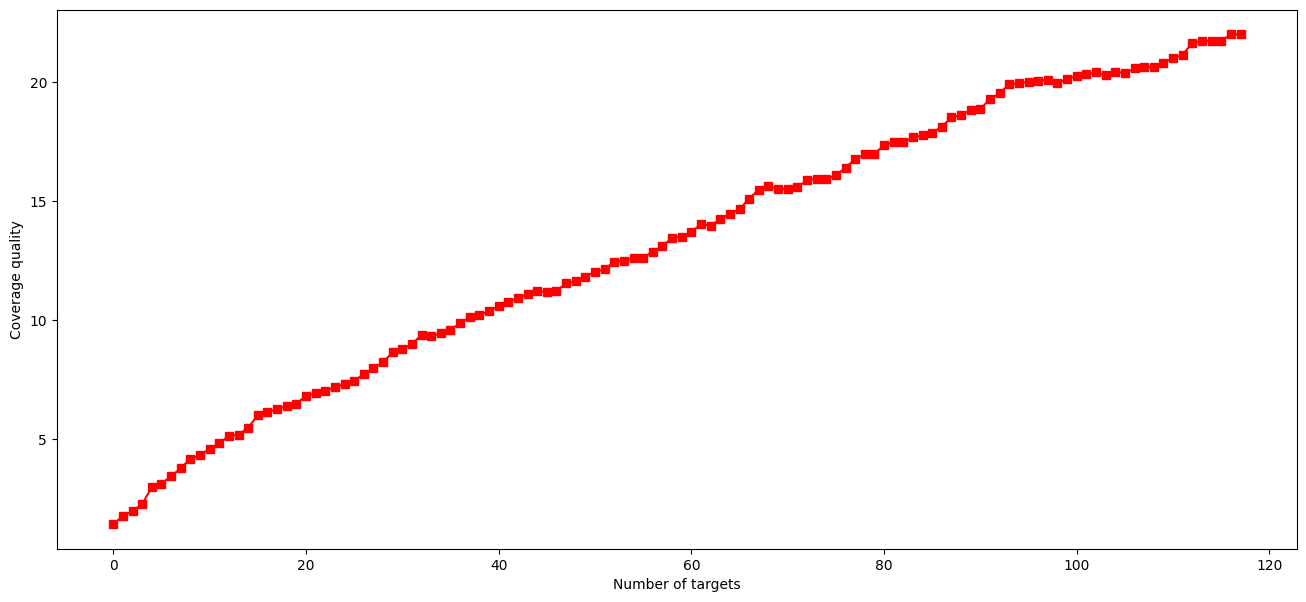

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(CQ_fs_avg))
plt.plot(x_axis, CQ_fs_avg, 'r-')
plt.plot(x_axis, CQ_fs_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Coverage quality")
plt.show()

In [8]:
index = range(0, 118, 3)

In [9]:
ACT_fs_ilp = []
for i in range(10):
  act = []
  for id in tqdm.tqdm(index):
    dt = fs_data[i]['small'][id]
    achieved_coverage, mask = solve_ILP(dt, verbose=False)
    act_score = activated_sensors(dt['n'], dt['q'], mask)
    act.append(act_score)
  ACT_fs_ilp.append(act)


100%|██████████| 40/40 [00:07<00:00,  5.01it/s]


In [10]:
ACT_fs_avg_ilp = np.mean(ACT_fs_ilp, axis=0)

In [11]:
ACT_fs_avg_ilp

array([ 2.6,  4.1,  6.4,  8.3, 10. , 11.4, 12.3, 13.3, 14.1, 15.5, 17.1,
       18.3, 18.8, 19.6, 20.4, 20.9, 21.5, 22.3, 22.8, 23.3, 23.8, 24.1,
       24.8, 25.2, 25.7, 25.8, 26. , 26.2, 26.5, 26.9, 27.2, 27.5, 27.8,
       27.8, 28.1, 28.3, 28.3, 28.4, 28.6, 28.6])

In [12]:
with open("/content/act_fs_ilp.npy", "wb") as f:
  np.save(f, ACT_fs_avg_ilp)

## Fixed target

In [ ]:
DI_ft_small = []
VAR_ft_small = []
CQ_ft_small = []
for i in range(10):
  di = []
  var = []
  cq = []
  for dt in tqdm.tqdm(ft_data[i]['small']):
    achieved_coverage, mask = solve_ILP(dt, verbose=False)
    DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
    var_score = variance(np.asarray(dt['K']), achieved_coverage)
    cq_score = coverage_quality(mask, dt)
    di.append(DI_score)
    var.append(var_score)
    cq.append(cq_score)
  DI_ft_small.append(di)
  VAR_ft_small.append(var)
  CQ_ft_small.append(cq)


100%|██████████| 118/118 [00:42<00:00,  2.79it/s]


In [ ]:
DI_ft_avg = np.mean(DI_ft_small, axis=0)
VAR_ft_avg = np.mean(VAR_ft_small, axis=0)
CQ_ft_avg = np.mean(CQ_ft_small, axis=0)

In [ ]:
# di_ft
!gdown 1blr_TQkKzAJIFG5meFmLYoncbRdqFxwU
# var_ft
!gdown 1Tyx4cW62K4ccjbpOBmj4wi3RlR1P47tV
# cq_ft
!gdown 1YQqCfSCqeUfWqWCIICl9UufeZsQ16mWp

Downloading...
From: https://drive.google.com/uc?id=1blr_TQkKzAJIFG5meFmLYoncbRdqFxwU
To: /content/distance_index_fix_target.csv
100% 2.63k/2.63k [00:00<00:00, 15.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Tyx4cW62K4ccjbpOBmj4wi3RlR1P47tV
To: /content/variance_fix_target.csv
100% 2.59k/2.59k [00:00<00:00, 16.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YQqCfSCqeUfWqWCIICl9UufeZsQ16mWp
To: /content/cq_ft.csv
100% 2.55k/2.55k [00:00<00:00, 12.8MB/s]


In [ ]:
di_ft = pd.read_csv('/content/distance_index_fix_target.csv')
df = pd.DataFrame({'ILP': DI_ft_avg,
                   'PIQP': di_ft['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Distance_Index_ft.csv')

In [ ]:
var_ft = pd.read_csv('/content/variance_fix_target.csv')
df = pd.DataFrame({'ILP': VAR_ft_avg,
                   'PIQP': var_ft['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/Variance_ft.csv')

In [ ]:
cq_ft = pd.read_csv('/content/cq_ft.csv')
df = pd.DataFrame({'ILP': CQ_ft_avg,
                   'PIQP': cq_ft['PIQP']})
df.to_csv(index=False)

df.to_csv('/content/CQ_ft.csv')

### Distance index

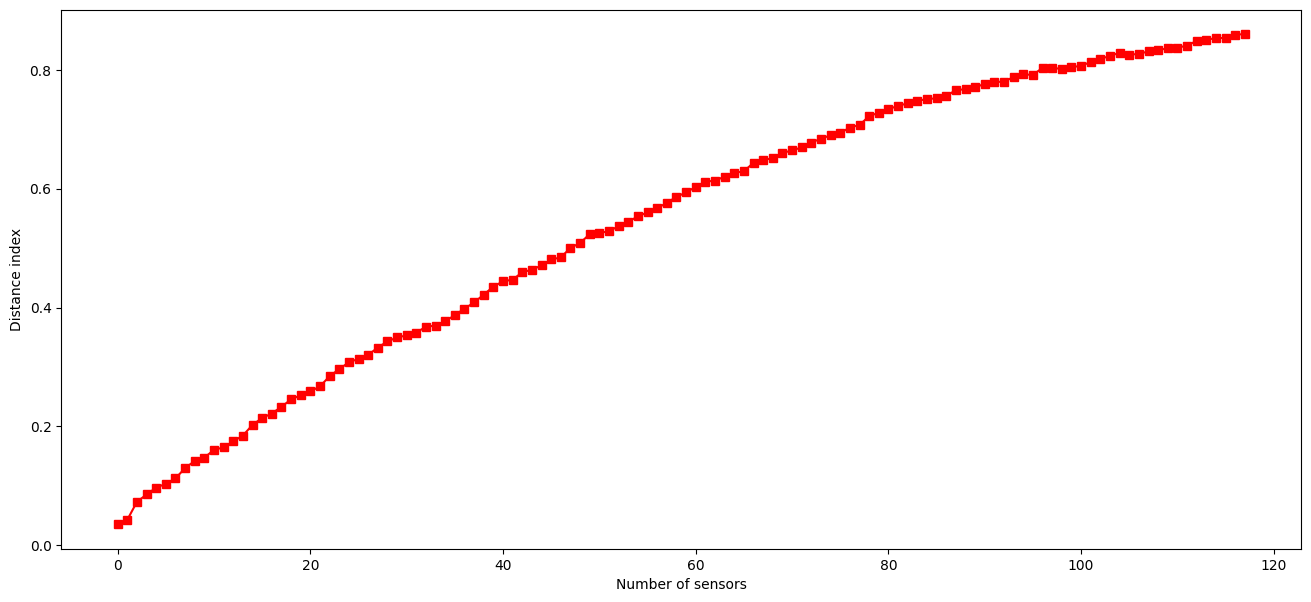

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(DI_ft_avg))
plt.plot(x_axis, DI_ft_avg, 'r-')
plt.plot(x_axis, DI_ft_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Distance index")
plt.show()

### Variance

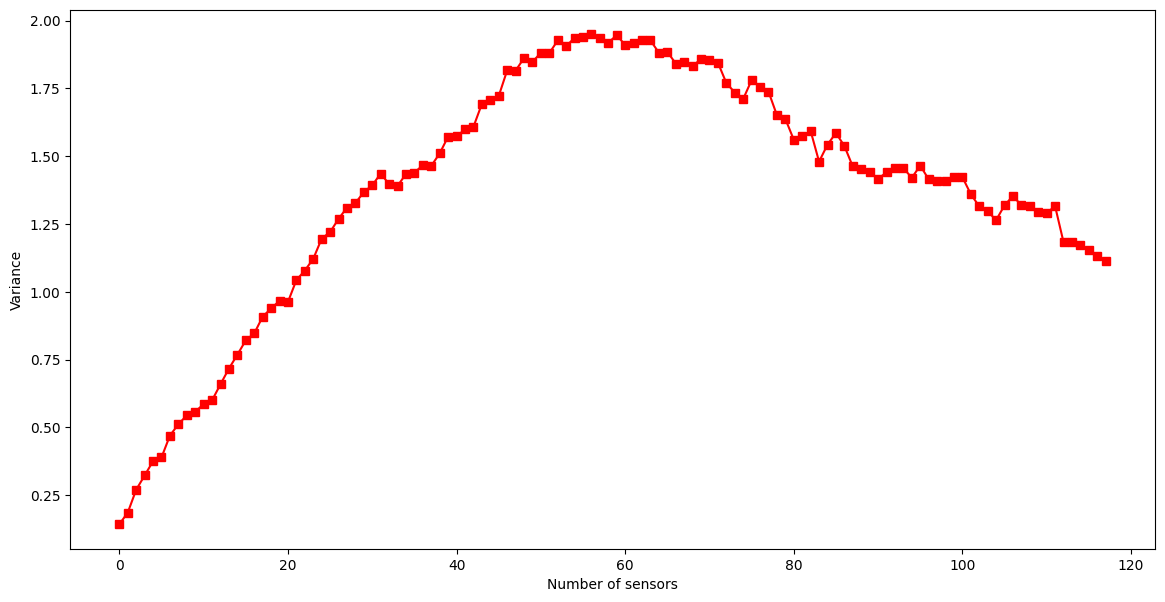

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(VAR_ft_avg))
plt.plot(x_axis, VAR_ft_avg, 'r-')
plt.plot(x_axis, VAR_ft_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Variance")
plt.show()

### CQ

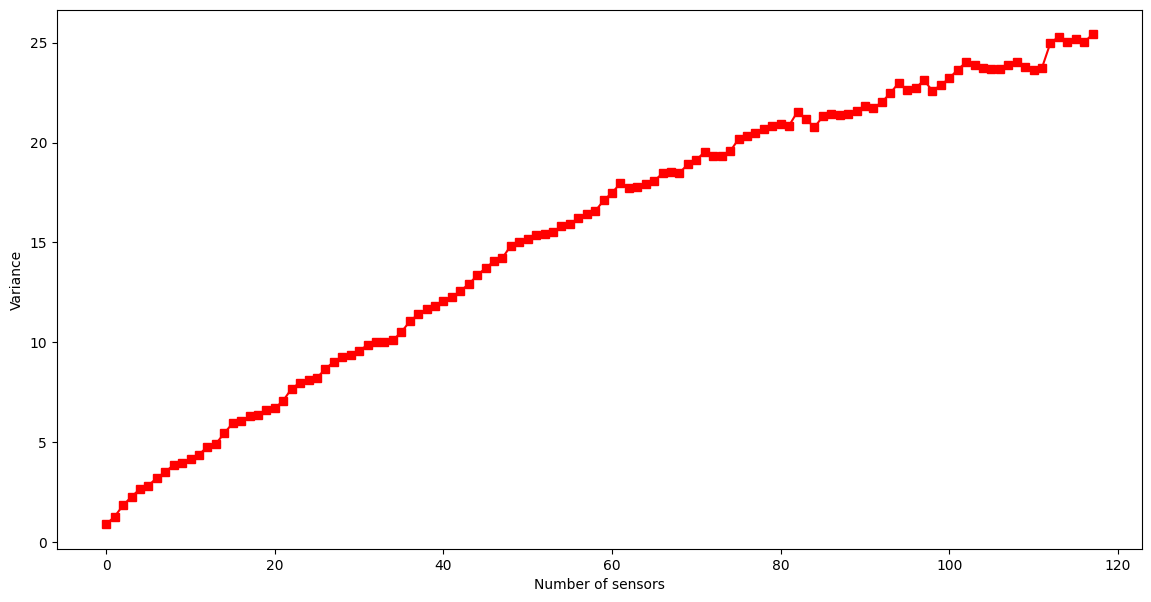

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(CQ_ft_avg))
plt.plot(x_axis, CQ_ft_avg, 'r-')
plt.plot(x_axis, CQ_ft_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Variance")
plt.show()

### Activate sensor

In [ ]:
ACT_ft_small = []
for i in range(10):
  act = []
  for dt in tqdm.tqdm(ft_data[i]['small']):
    achieved_coverage, mask = solve_ILP(dt, verbose=False)
    act_score = activated_sensors(dt['n'], dt['q'], mask)
    act.append(act_score)
  ACT_ft_small.append(act)


100%|██████████| 118/118 [00:22<00:00,  5.25it/s]


In [ ]:
ACT_ft_avg = np.mean(ACT_ft_small, axis=0)

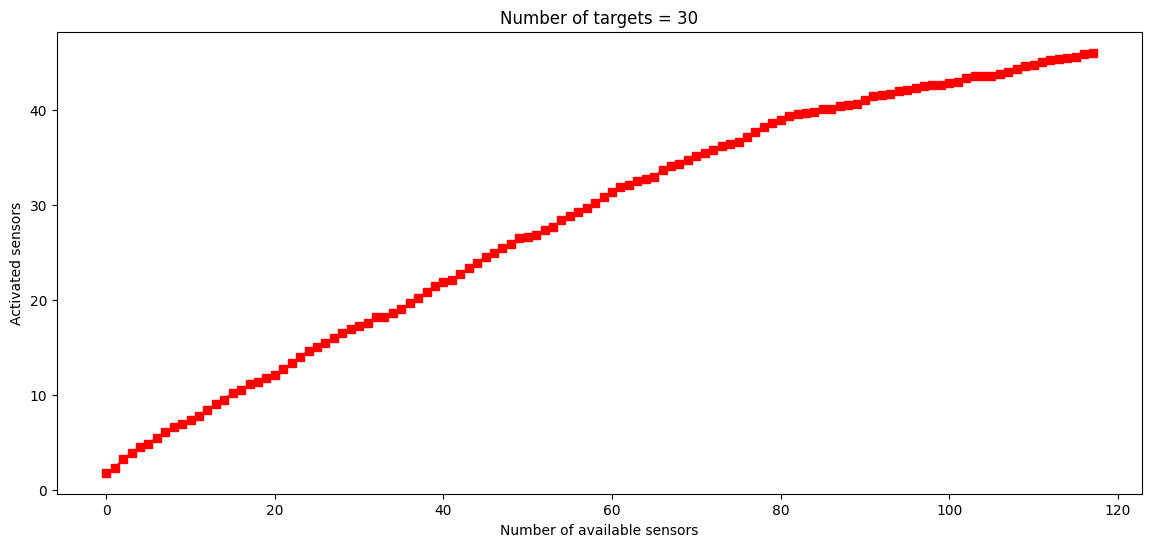

In [ ]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(ACT_ft_avg))
plt.plot(x_axis, ACT_ft_avg, 'r-')
plt.plot(x_axis, ACT_ft_avg, 'rs')
plt.xlabel("Number of available sensors")
plt.ylabel("Activated sensors")
plt.title(f'Number of targets = {30}')
plt.show()

In [ ]:
!gdown 1313IQz0U9MI8bFjYm65aNFDOIWx7FU-m

Downloading...
From: https://drive.google.com/uc?id=1313IQz0U9MI8bFjYm65aNFDOIWx7FU-m
To: /content/active_fix_target.csv
100% 2.35k/2.35k [00:00<00:00, 8.13MB/s]


In [ ]:
act_ss = pd.read_csv("/content/active_fix_target.csv")

In [24]:
with open("ilp_fs_small.pkl", 'rb') as f:
  fs11_data = pickle.load(f)

In [34]:
xxx=fs11_data[0]

In [35]:
len(xxx)

10

In [36]:
len(xxx[0])

118

In [38]:
len(xxx[0])

118